# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.913147,False,-0.842913
1,0.058275,False,1.350328
2,-1.166946,False,-0.688998
3,0.458789,False,-0.438620
4,2.176164,True,6.196012
...,...,...,...
995,1.221105,True,6.164691
996,0.286706,True,4.000340
997,0.402994,True,3.339937
998,-2.158400,False,-2.137273


<Axes: xlabel='v0'>

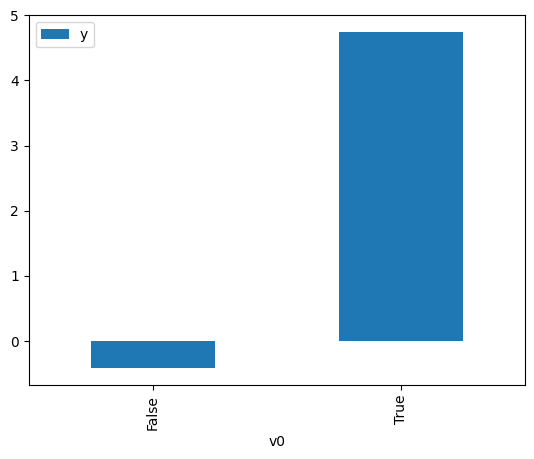

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

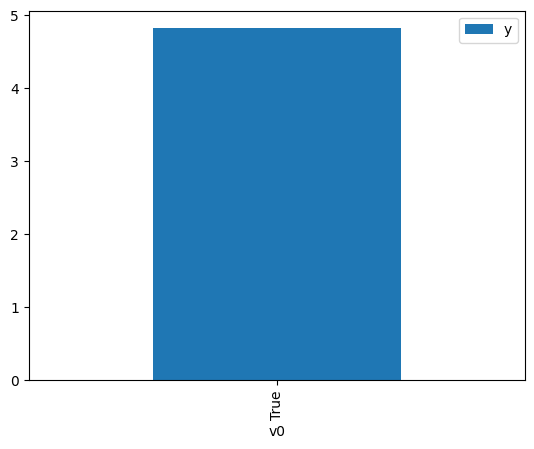

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.215091,False,1.138710,0.633970,1.577361
1,0.184159,False,-0.294875,0.429330,2.329212
2,-1.648880,False,-0.226753,0.971911,1.028900
3,-0.026363,False,0.029439,0.538700,1.856321
4,-1.141809,False,-1.858592,0.923072,1.083339
...,...,...,...,...,...
995,1.500217,False,-0.108344,0.045944,21.765851
996,-0.972943,False,-1.679009,0.893988,1.118583
997,-0.918276,False,-1.127321,0.882670,1.132926
998,1.434714,False,0.327292,0.052327,19.110617


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.376142,True,3.807498,0.048602,20.575180
1,0.089889,True,4.782430,0.521910,1.916041
2,-0.473253,True,4.655816,0.251903,3.969775
3,0.829652,True,7.243798,0.836548,1.195388
4,-1.322700,True,4.901237,0.054031,18.507730
...,...,...,...,...,...
995,-0.265706,True,3.899294,0.341863,2.925147
996,0.304224,True,6.795187,0.630731,1.585462
997,-0.606255,True,4.988782,0.203223,4.920711
998,-0.468027,True,5.805760,0.253966,3.937535


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              5202.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:31:54   Log-Likelihood:                         -1412.0
No. Observations:                1000   AIC:                                      2828.
Df Residuals:                     998   BIC:                                      2838.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6891      0.031     22.523      0.000       0.629       0.749
x2             4.9468      0.053     92.589      0.000       4.842       5.052
==============================================================================
Omnibus:                        0.035   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.083
Skew:                          -0.004   Prob(JB):                        0.959
Kurtosis:                       2.956   Cond. No.                         1.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""